In [1]:
pip install yfinance

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install ta

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta  # Technical Analysis library
%pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [4]:


# Define the stock ticker (f"{}" in this case),getting its name
ticker = '600519.SS'
ticker_info = yf.Ticker(ticker)
company_name = ticker_info.info.get('longName')
# Download data from ( ) to the most recent available date
new_data = yf.download(ticker, start='1990-01-01', end='2025-12-01')

# Preview the new data
print(new_data.head())


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['600519.SS']: ConnectionError(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out."))


Empty DataFrame
Columns: [(Adj Close, 600519.SS), (Close, 600519.SS), (High, 600519.SS), (Low, 600519.SS), (Open, 600519.SS), (Volume, 600519.SS)]
Index: []


In [5]:
# Access the 'Close' column using the correct multi-level index
close_prices = new_data[('Close', ticker)]

# Check if it is a 1D pandas Series
print(close_prices.shape) 


(0,)


In [6]:
# Access the 'Close' column using the correct multi-level index
close_prices = new_data[('Close', ticker)]

# Step 3: Calculate technical indicators
# Calculate 20-period SMA (Simple Moving Average)
new_data[('SMA_20', '')] = new_data[('Close', ticker)].rolling(window=20).mean()

# Calculate 20-period EMA (Exponential Moving Average)
new_data[('EMA_20', '')] = new_data[('Close', ticker)].ewm(span=20, adjust=False).mean()

# Calculate 14-period RSI (Relative Strength Index)
new_data[('RSI', '')] = ta.momentum.RSIIndicator(close_prices, window=14).rsi()

# Calculate Bollinger Bands (Upper and Lower)
new_data[('Bollinger_Upper', '')] = new_data[('SMA_20', '')] + 2 * new_data[('Close', ticker)].rolling(window=20).std()
new_data[('Bollinger_Lower', '')] = new_data[('SMA_20', '')] - 2 * new_data[('Close', ticker)].rolling(window=20).std()

# Handle NaN values caused by rolling calculations (forward fill or drop)
new_data.ffill(inplace=True)

new_data.dropna(inplace=True)  # Alternatively, drop rows with NaN values

# Preview the data with the new technical indicators
print(new_data.head())


Empty DataFrame
Columns: [(Adj Close, 600519.SS), (Close, 600519.SS), (High, 600519.SS), (Low, 600519.SS), (Open, 600519.SS), (Volume, 600519.SS), (SMA_20, ), (EMA_20, ), (RSI, ), (Bollinger_Upper, ), (Bollinger_Lower, )]
Index: []


Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


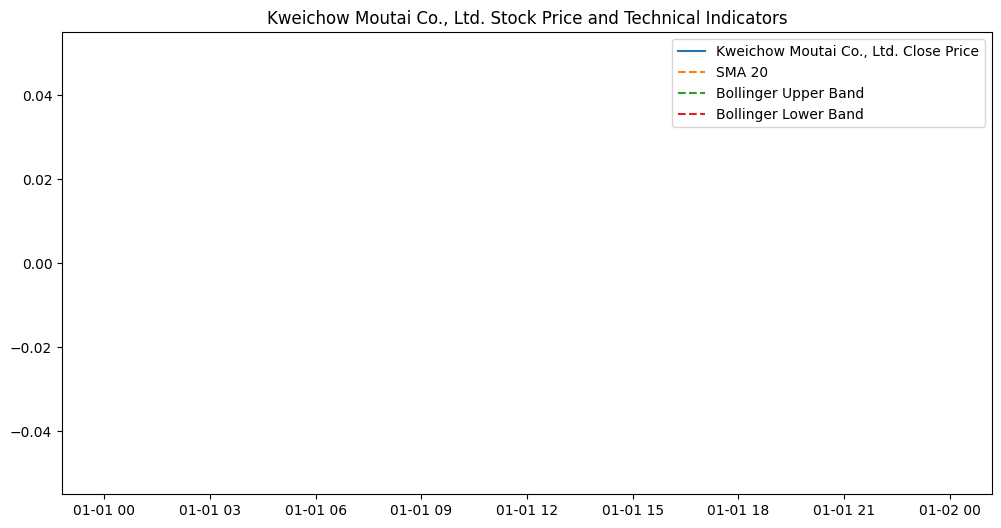

In [7]:
%pip install matplotlib

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(new_data['Close'], label=f'{company_name} Close Price')
plt.plot(new_data['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(new_data['Bollinger_Upper'], label='Bollinger Upper Band', linestyle='--')
plt.plot(new_data['Bollinger_Lower'], label='Bollinger Lower Band', linestyle='--')
plt.legend(loc='best')
plt.title(f'{company_name} Stock Price and Technical Indicators')
plt.show()


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Define the columns to normalize
features_to_normalize = ['Open', 'High', 'Low', 'Close', 'Volume', 
                         'SMA_20', 'EMA_20', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower']

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize the selected features
new_data[features_to_normalize] = scaler.fit_transform(new_data[features_to_normalize])

# Preview the normalized data
print(new_data.head())


ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required by MinMaxScaler.

In [11]:
def create_sequences(data, sequence_length, target_column='Close'):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        # Select the features (excluding 'Date' and target column)
        features = data.iloc[i-sequence_length:i].drop(columns=[target_column]).values
        X.append(features)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

# Set sequence length (e.g., 60 days)
sequence_length = 60

# Create sequences for the model (e.g., 'Close' as target)
X, y = create_sequences(new_data, sequence_length, target_column='Close')

# Check shapes of features and target
print(f"Features Shape: {X.shape}, Target Shape: {y.shape}")

NameError: name 'new_data' is not defined

In [ ]:
from sklearn.model_selection import train_test_split

# Initial split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Further split training+validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.18, random_state=42)  # 18% of 85% ≈ 15%

# Print shapes of the splits
print(f"Training Data: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation Data: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Testing Data: X_test={X_test.shape}, y_test={y_test.shape}")


In [93]:

np.savez(f'processed_{company_name}_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, X_val=X_val, y_val=y_val)


In [1]:
# Load preprocessed data
company_name = 'Kweichow Moutai Co., Ltd.'

import numpy as np
data = np.load(f'processed_{company_name}_data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
X_val = data['X_val']
y_val = data['y_val']

print(f"Data loaded successfully: X_train={X_train.shape}, X_val={X_val.shape} X_test={X_test.shape}")


Data loaded successfully: X_train=(3966, 60, 9), X_val=(871, 60, 9) X_test=(854, 60, 9)


In [2]:
%pip install tensorflow tensorflow-addons optuna shap linformer


Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from linformer import Linformer

# Define the TCN block
def TCN_Block(input_shape, num_filters=64, kernel_size=3, dilation_rates=[1, 2, 4, 8], dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for rate in dilation_rates:
        x = layers.Conv1D(
            filters=num_filters,
            kernel_size=kernel_size,
            dilation_rate=rate,
            padding='causal',
            activation='relu',
            kernel_regularizer=regularizers.l2(1e-4)  # L2 Regularization
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
    return tf.keras.Model(inputs, x, name="TCN_Block")


# Define the optimized Transformer block using MultiHeadAttention
def Optimized_Transformer_Block(input_shape, num_heads=4, ff_dim=64, dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)

    # Multi-head attention layer
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization()(attention_output + inputs)  # Residual connection

    # Feed-forward layer
    ff_output = layers.Dense(ff_dim, activation='relu')(attention_output)
    ff_output = layers.Dropout(dropout_rate)(ff_output)
    ff_output = layers.Dense(input_shape[-1])(ff_output)
    ff_output = layers.LayerNormalization()(ff_output + attention_output)  # Residual connection

    return tf.keras.Model(inputs, ff_output, name="Optimized_Transformer_Block")


def TCN_Transformer_Model(input_shape, tcn_filters=64, transformer_heads=4, transformer_ff_dim=64, dropout_rate=0.2):
    inputs = tf.keras.Input(shape=input_shape)

    # TCN Block
    tcn = TCN_Block(input_shape, num_filters=tcn_filters, dropout_rate=dropout_rate)(inputs)

    # Transformer Block
    transformer = Optimized_Transformer_Block(input_shape=(tcn.shape[1], tcn.shape[2]),
                                              num_heads=transformer_heads,
                                              ff_dim=transformer_ff_dim,
                                              dropout_rate=dropout_rate)(tcn)

    # Dense Layers for prediction
    x = layers.GlobalAveragePooling1D()(transformer)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='linear')(x)

    return tf.keras.Model(inputs, outputs, name="TCN_Transformer_Model")


In [4]:
# Define the input shape
input_shape = (60, 9)  # 60 time steps, 9 features

# Instantiate the model
model = TCN_Transformer_Model(input_shape=input_shape, 
                              tcn_filters=64, 
                              transformer_heads=4, 
                              transformer_ff_dim=64, 
                              dropout_rate=0.3)

# Compile the model
model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['mae'])

# Summary of the model
model.summary()


Model: "TCN_Transformer_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TCN_Block (Functional)          │ (None, 60, 64)         │        39,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Optimized_Transformer_Block     │ (None, 60, 64)         │        74,944 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,041 (465.00 KB)

 Trainable params: 118,529 (463.00 KB)

 Non-trainable params: 512 (2.00 KB)

In [5]:
history = model.fit(
    X_train, y_train,                  # Training data
    validation_data=(X_val, y_val),    # Validation data
    epochs=50,                         # Number of epochs
    batch_size=32,                     # Batch size
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5)
    ]
)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0774 - mae: 0.1513 - val_loss: 0.0678 - val_mae: 0.1282 - learning_rate: 0.0010
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0327 - mae: 0.0540 - val_loss: 0.0343 - val_mae: 0.0780 - learning_rate: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0307 - mae: 0.0483 - val_loss: 0.0350 - val_mae: 0.0902 - learning_rate: 0.0010
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0277 - mae: 0.0413 - val_loss: 0.0354 - val_mae: 0.0991 - learning_rate: 0.0010
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0253 - mae: 0.0380 - val_loss: 0.0448 - val_mae: 0.1257 - learning_rate: 0.0010
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0237 - mae: 0.0375 - val_loss: 0.0413 - val_mae: 0.1184 - learning_rate: 0.0010
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0220 - mae: 0.0372 - val_loss: 0.0417 - val_mae: 0.1353 - learning_rate: 0.0010

In [6]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Mean Absolute Error: {test_mae}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mae: 0.0149
Test Loss: 0.0012061642482876778
Test Mean Absolute Error: 0.015262017026543617


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


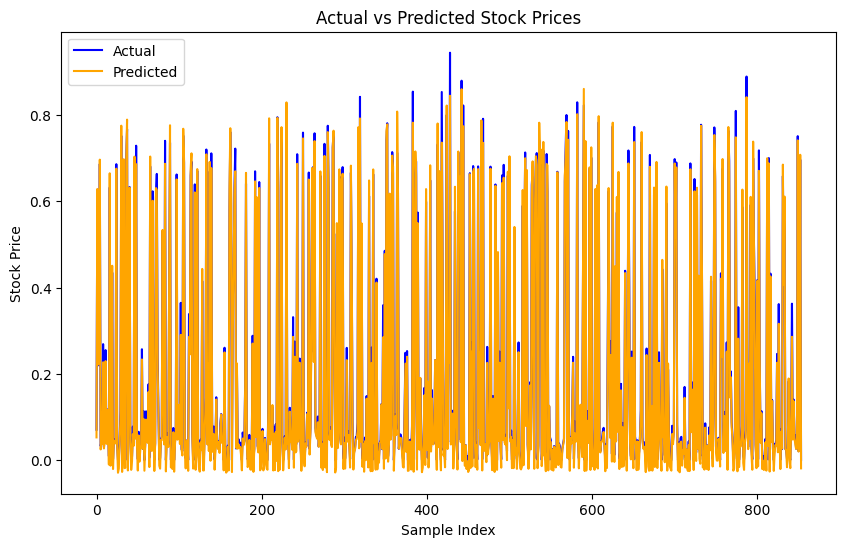

In [7]:

import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='orange')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Sample Index")
plt.ylabel("Stock Price")
plt.legend()
plt.show()




In [8]:
from sklearn.metrics import r2_score

# Calculate R² score
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2}")

R² Score: 0.9939127201231219


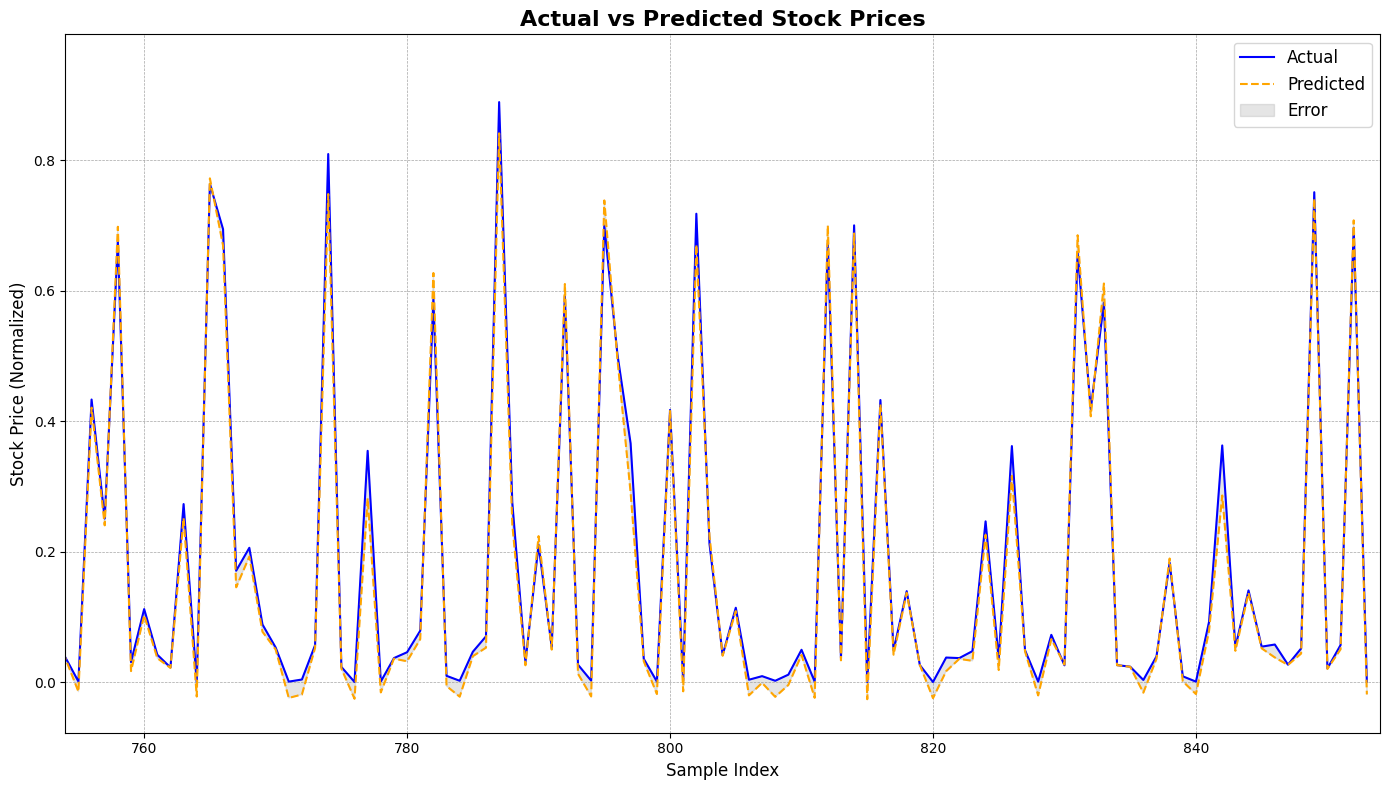

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Create an index for plotting
index = np.arange(len(y_test))

# Plot actual vs predicted values
plt.figure(figsize=(14, 8))  # Increase figure size for better visibility
plt.plot(index, y_test, label="Actual", color='blue', linewidth=1.5)
plt.plot(index, y_pred, label="Predicted", color='orange', linestyle='--', linewidth=1.5)

# Add gridlines
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Highlight differences
plt.fill_between(index, y_test.flatten(), y_pred.flatten(), color='gray', alpha=0.2, label="Error")

# Title and labels
plt.title("Actual vs Predicted Stock Prices", fontsize=16, fontweight='bold')
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Stock Price (Normalized)", fontsize=12)

# Add legend
plt.legend(loc="upper right", fontsize=12)

# Zoom into a specific region (optional)
start, end = len(y_pred)-100,len(y_pred)  #Adjust range as needed
plt.xlim(start, end)  # Show detailed view of the specified range

# Display the plot
plt.tight_layout()
plt.show()
